# Optmización: Tarea 4
## Oscar Esaú Peralta Rosales

Implement the following methods: cubic interpolation, Barzilai-Borwein and Zhang-Hager. Apply the previous implementations to the following functions and compare the results with respect to: number of iterations, norm of the gradient $||∇f (xk )||$ and the error $|f(x_k) − f (x^∗)|$.

In [0]:
import time

from typing import Callable, Dict, Tuple
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import ldl

# from line_search import gradient_descent, newton_method


## Funciones 

### Rosembrock function, for n = 100

In [0]:
def f2(x :np.array, n :int=100) -> float:
    """ Compute the evaluation for Extended Rosembrock function with n=100
        Args:
        x: Array of length=n with x's parameters
        n: Rosembrock, n = 100
        
        Returns:
            Evaluation of f(X)
    """
    ans = 0.0
    for i in range(n-1):
        ans += 100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2
    return ans


def f2_grad(x :np.array, n :int=100) -> np.array:
    """ Compute the gradient evaluation for Extended Rosembrock function with n=2 
        Args:
        x: Array of length=n with x's parameters
        n: Rosembrock, n = 100
        
        Returns:
            Gradient of f(x1, ..., xn), array with lenght=n
    """
    # grad = np.zeros(n, dtype=np.float64)
    # for i in range(n-1):
    #     grad[i] = -400 * x[i+1] * x[i] + 400 * x[i]**3 + 2 * x[i] -2
    # grad[n-1] = 200 * (x[n-1] - x[n-2]**2)
    # return grad
    grad=np.array([-400*(x[1]-x[0]**2)*x[0]-2*(1-x[0])])
    
    for i in range(1, n-1): 
        grad=np.append(grad,[200*(x[i]-x[i-1]**2)-400*(x[i+1]-x[i]**2)*x[i]-2*(1-x[i])])
    
    grad=np.append(grad,[200*(x[99] - x[98]**2)])
    
    return grad


def f2_hess(x :np.array, n :int=100) -> np.array:
    """ Compute the Hessian evaluation for Extended Rosembrock function with n=2 
        Args:
        x: Array of length=n with x's parameters
        
        Returns:
            Hessian of f(x1, ..., xn), Matrix with size=nxn
    """
    hess = np.zeros((n, n), dtype=np.float64)
    for i in range(n-1):
            hess[i][i] = -400 * x[i+1] + 1200 * x[i]**2 + 2
            hess[i][i+1] = -400 * x[i]
    hess[n-1][n-1] = 200.0
    return hess



### Wood function

In [0]:
def f3(x :np.array) -> float:
    """ Compute the evaluation for Wood Function function with n=100
        Args:
        x: Array of length=4 with x's parameters
        
        Returns:
            Evaluation of f(X)
    """
    f1 = 100*(x[0]**2 - x[1])**2 + (x[0]-1)**2 + 10.1*(x[1]-1)**2 + (x[2]-1)**2 
    f2 = 10.1*(x[3]-1)**2 + 90*(x[2]**2-x[3])**2 +19.8*(x[1]-1)*(x[3]-1)
    return f1 + f2
    # ans = 100 * (x[0]**2 - x[1]) + (x[0] - 1)**2 + (x[2] - 1)**2 + 90 * (x[2]**2 - x[3])**2
    # ans += 10.1 * ((x[1] - 1)**2 + (x[3] - 1)**2) + 19.8 * (x[1] - 1) * (x[3] - 1)
    # return ans


def f3_grad(x :np.array) -> np.array:
    """ Compute the gradient evaluation for Extended Rosembrock function with n=2 
        Args:
        x: Array of length=4 with x's parameters
        
        Returns:
            Gradient of f(x1, x2, x3, x4), array with lenght=4
    """
    grad = np.zeros(4, dtype=np.float64)
    grad[0] = 400 * x[0]**3 - 400 * x[0] * x[1] + 2 * x[0] - 2
    grad[1] = -200 * (x[0]**2 - x[1]) + 20.2 * (x[1] - 1) + 19.8 * x[3] - 19.8
    grad[2] = 2 * x[2] - 2 + 360 * x[2]**3 - 360 * x[3] * x[2]
    grad[3] = -180 * (x[2]**2 - x[3]) + 20.2 * (x[3] - 1) + 19.8 * (x[1] -1)
    return grad


def f3_hess(x :np.array) -> np.array:
    """ Compute the Hessian evaluation for Extended Rosembrock function with n=2 
        Args:
        x: Array of length=4 with x's parameters
        
        Returns:
            Hessian of f(x1, x2, x3, x4), Matrix with size=4x4
    """
    hess = np.zeros((4, 4), dtype=np.float64)
    
    hess[0][0] = 1200 * x[0]**2 - 400 * x[1] + 2
    hess[0][1] = hess[1][0] = -400 * x[0]
    hess[1][1] = hess[3][3] = 220.2
    hess[2][2] = 1080 * x[2]**2 - 360 * x[3] + 2
    hess[3][1] = hess[1][3] = 19.8
    hess[3][2] = hess[2][3] = -360 * x[2]
    
    return hess

### Descenso de Gradiente y Newton

##  cubic interpolation

In [0]:
 # Stop criterias
stop_x = lambda x_k, x_k_next: np.linalg.norm(x_k_next - x_k) / max(np.linalg.norm(x_k), 1.0)
stop_f = lambda f_x_k, f_x_k_next: np.abs(f_x_k_next - f_x_k) / max(np.abs(f_x_k), 1.0)
stop_g = lambda grad_k: np.linalg.norm(grad_k)


def cubic_interpolation(X: np.array,
                        f: Callable[[np.array], np.array],
                        g: Callable[[np.array], np.array],
                        tol_x: float=1e-12,
                        tol_g: float=1e-12,
                        tol_f: float=1e-12,
                        alpha: float=1e-2,
                        c1: float=1e-4,
                        mxitr: int=1000,
                        **kwargs):
    Result = namedtuple('Result', 'x_log f_log g_norm_log')

    # History of values computed
    x_log = []; f_log = []
    stop_x_log = []; stop_f_log = []; stop_g_log = []

    x_k = X;
    g_k = g(x_k)
    
    k = 0
    alpha_k = alpha
    alpha_0 = alpha
    alpha_1 = alpha
    alpha_2 = alpha

    # Logs
    x_log = [x_k]
    f_log = [f(x_k, **kwargs.get('f_kwargs', {}))]
    g_norm_log = [np.linalg.norm(g_k)]
    
    # Phi and armijo
    phi_alpha = lambda _x, _grad, _alpha: f(_x - _alpha * _grad)
    phi_0 = lambda _x: f(_x)
    phi_p0 = lambda _grad: - np.dot(_grad, _grad)
    armijo = lambda _x, _grad, _alpha: phi_alpha(_x, _grad, _alpha) <= phi_0(_x) + c1 * _alpha * phi_p0(_grad)

    def _get_abc(_x, _grad, _alpha_0, _alpha_1):
        f1 = _alpha_1**2 * _alpha_0**2 * (_alpha_1 - _alpha_0)
        m1 = np.array([
            [_alpha_0**2, - _alpha_1**2],
            [- _alpha_0**3, _alpha_1**3]
        ])
        m2 = np.array([
            [phi_alpha(_alpha_1) - phi_p0(_grad)*_alpha_1 - phi_0(_x)],
            [phi_alpha(_alpha_0) - phi_p0(_grad)*_alpha_0 - phi_0(_x)]
        ])
        a, b = (1.0 / f1) * (m1 @ m2)
        c = phi_0(_x)

        return a, b, c


    def _get_alpha_1(_x, _grad, _alpha_0):
        f1 = - _alpha_0**2 * phi_p0(_grad)
        f2 = phi_alpha(_x, _grad, _alpha_0) - phi_p0(_grad) * _alpha_0 - phi_0(_x)
        return f1 / (2.0*f2)

    def _get_alpha_2(a, b, c):
        return (-b + np.sqrt(b**2 - 3*a*c)) / (3*a)

    k = 0
    while np.linalg.norm(g_k) > tol_g and k < mxitr:
        alpha_0 = alpha_k

        if armijo(x_k, g_k, alpha_0):
            pass
        else:
            alpha_1 = _get_alpha_1(x_k, g_k, alpha_0)
            if armijo(x_k, g_k, alpha_1):
                alpha_k = alpha_1
            else:
                a, b, c = _get_abc(x_k, grad_k, alpha_0, alpha_1)
                alpha_2 = _get_alpha_2(a, b, c)
                while not armijo(x_k, grad_k, alpha2):
                    alpha_0 = alpha_1
                    alpha_1 = alpha_2
                    a, b, c = _get_abc(x_k, grad_k, alpha_0, alpha_1)
                    alpha_2 = _get_alpha_2(a, b, c)
                alpha_k = alpha_2

        x_k = x_k - alpha_k * g_k
        x_log.append(x_k)
        
        g_k = g(x_k)
        g_norm_log.append(np.linalg.norm(g_k))
        
        f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))

        k += 1

        # Stop criteria
        if stop_x(x_log[-2], x_log[-1]) <= tol_x or stop_f(f_log[-2], f_log[-1]) <= tol_f:
            break

    return Result(np.array(x_log), np.array(f_log), np.array(g_norm_log))


iters: 10001
g norm 9.997764922669756
f error 3.9866306173700155


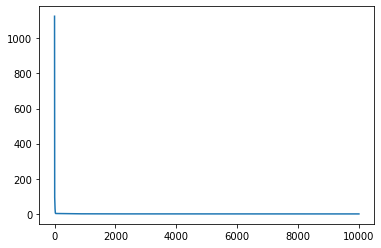

In [0]:
X = np.ones(100, dtype=np.float64)
X[0] = X[-2] = -1.2
xop = np.ones(100)

params = {
    'X': X,
    'f': f2,
    'g': f2_grad,
    'tol_x': 1e-10,
    'tol_f': 1e-10,
    'tol_g': 1e-10,
    'alpha': 1e-3,
    'c1': 1e-4,
    'mxitr': 10000
}

ans = cubic_interpolation(**params)

print("iters: %d" % len(ans.x_log))
print("g norm", np.linalg.norm(ans.x_log[-1]))
print("f error", ans.f_log[-1] - f2(xop))
plt.plot(ans.g_norm_log)
# plt.plot(ans.f_log)

iters: 10001
g norm 1.9180671098530873
f error 7.87696275603011


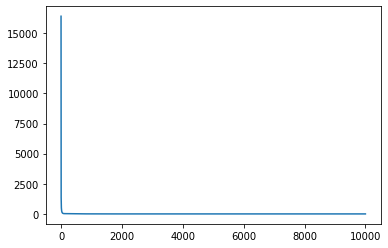

In [0]:
X = np.array([-3, -1, -3, -1], dtype=np.float64)


params = {
    'X': X,
    'f': f3,
    'g': f3_grad,
    'tol_x': 1e-12,
    'tol_f': 1e-12,
    'tol_g': 1e-12,
    'alpha': 1e-3,
    'c1': 1e-4,
    'mxitr': 10000
}

ans = cubic_interpolation(**params)

xop = np.ones(4)
print("iters: %d" % len(ans.x_log))
print("g norm", np.linalg.norm(ans.x_log[-1]))
print("f error", ans.f_log[-1] - f3(xop))
plt.plot(ans.g_norm_log)
# plt.plot(ans.f_log)

## Barzilai Borwein

In [0]:
def barzilai_borwein(X: np.array,
                     f: Callable[[np.array], np.array],
                     g: Callable[[np.array], np.array],
                     tol_x: float=1e-12,
                     tol_g: float=1e-12,
                     tol_f: float=1e-12,
                     mxitr: int=100,
                     **kwargs):
    Result = namedtuple('Result', 'x_log f_log g_norm_log')

    # History of values computed
    # x_log = []; f_log = []
    # stop_x_log = []; stop_f_log = []; stop_g_log = []

    x_log = []
    f_log = []
    g_norm_log = []

    x_k_prev = None; 
    x_k = X;
    x_log.append(x_k)

    g_k_prev = None
    g_k = g(x_k)
    g_norm_log.append(np.linalg.norm(g_k))

    f_k = f(x_k, **kwargs.get('f_kwargs', {}))
    f_log.append(f_k)

    k = 0
    alpha_k = kwargs.get('alpha', 1e-2)
    
    while np.linalg.norm(g_k) > tol_g and k < mxitr:
        if k == 0:
            # h_k = H(x_k, **kwargs.get('g_kwargs', {}))
            # alpha_k = (g_k @ g_k) / (g_k @ h_k @ g_k)
            pass
        else:
            s_k1 = x_k - x_k_prev
            y_k1 = g_k - g_k_prev
            alpha_k = np.dot(s_k1, y_k1) / np.dot(y_k1, y_k1)
        
        x_k_prev = x_k.copy()
        x_k = x_k_prev - alpha_k * g_k
        x_log.append(x_k)

        g_k_prev = g_k
        g_k = g(x_k, **kwargs.get('g_kwargs', {}))
        g_norm_log.append(np.linalg.norm(g_k))

        f_k = f(x_k, **kwargs.get('f_kwargs', {}))
        f_log.append(f_k)

        # Stop criteria
        if stop_x(x_log[-2], x_log[-1]) <= tol_x or stop_f(f_log[-2], f_log[-1]) <= tol_f:
            break

        k += 1

    return Result(np.array(x_log), np.array(f_log), np.array(g_norm_log))


iters: 953
g norm 10.000004252138693
f error 1.5070349038228916e-10


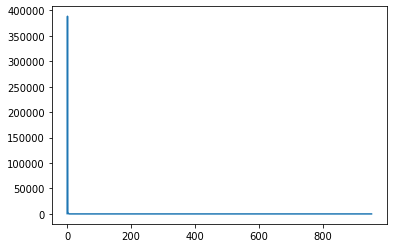

In [0]:
X = np.ones(100, dtype=np.float64)
X[0] = X[-2] = -1.2

xop = np.ones(100)

params = {
    'X': X,
    'f': f2,
    'g': f2_grad,
    'tol_x': 1e-12,
    'tol_f': 1e-12,
    'tol_g': 1e-12,
    'alpha': 1e-2,
    'mxitr': 10000
}

ans = barzilai_borwein(**params)

print("iters: %d" % len(ans.x_log))
print("g norm", np.linalg.norm(ans.x_log[-1]))
print("f error", ans.f_log[-1] - f2(xop))

# plt.plot(ans.g_norm_log)
plt.plot(ans.f_log)

In [0]:
ans.x_log[-1]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

iters: 207
g norm 2.0000000136250775
f error 3.298833444780957e-15


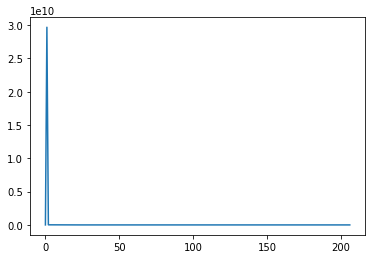

In [0]:
X = np.array([-3, -1, -3, -1], dtype=np.float64)

_lambda = 1
params = {
    'X': X,
    'f': f3,
    'g': f3_grad,
    'tol': 1e-10,
    'alpha': 1e-2,
    'mxitr': 10000
}

ans = barzilai_borwein(**params)

xop = np.ones(4)
print("iters: %d" % len(ans.x_log))
print("g norm", np.linalg.norm(ans.x_log[-1]))
print("f error", ans.f_log[-1] - f3(xop))
# plt.plot(ans.g_norm_log)
plt.plot(ans.f_log)

## Zhang-Hager

In [0]:
 # Stop criterias
stop_x = lambda x_k, x_k_next: np.linalg.norm(x_k_next - x_k) / max(np.linalg.norm(x_k), 1.0)
stop_f = lambda f_x_k, f_x_k_next: np.abs(f_x_k_next - f_x_k) / max(np.abs(f_x_k), 1.0)
stop_g = lambda grad_k: np.linalg.norm(grad_k)


def zhang_hager(X: np.array,
                f: Callable[[np.array], np.array],
                g: Callable[[np.array], np.array],
                tol_x: float=1e-12,
                tol_g: float=1e-12,
                tol_f: float=1e-12,
                alpha: float=1e-2,
                c1: float=1e-4,
                mxitr: int=1000,
                **kwargs):
    Result = namedtuple('Result', 'x_log f_log g_norm_log')

    # History of values computed
    x_log = []; f_log = []
    stop_x_log = []; stop_f_log = []; stop_g_log = []

    x_k = X;
    g_k = g(x_k)

    c_k = f(x_k, **kwargs.get('f_kwargs', {}))
    q_k = kwargs.get('q_k', 1.0)
    eta = kwargs.get('eta', 0.5)
    
    k = 0
    alpha_k = alpha
    alpha_0 = alpha
    alpha_1 = alpha
    alpha_2 = alpha

    # Logs
    x_log = [x_k]
    f_log = [c_k]
    g_norm_log = [np.linalg.norm(g_k)]
    
    # Phi and armijo
    phi_alpha = lambda _x, _grad, _alpha: f(_x - _alpha * _grad)
    phi_0 = lambda _x: f(_x)
    phi_p0 = lambda _grad: - np.dot(_grad, _grad)
    armijo = lambda _x, _grad, _alpha, _c: phi_alpha(_x, _grad, _alpha) <= _c + c1 * _alpha * phi_p0(_grad)

    def _get_abc(_x, _grad, _alpha_0, _alpha_1):
        f1 = _alpha_1**2 * _alpha_0**2 * (_alpha_1 - _alpha_0)
        m1 = np.array([
            [_alpha_0**2, - _alpha_1**2],
            [- _alpha_0**3, _alpha_1**3]
        ])
        m2 = np.array([
            [phi_alpha(_alpha_1) - phi_p0(_grad)*_alpha_1 - phi_0(_x)],
            [phi_alpha(_alpha_0) - phi_p0(_grad)*_alpha_0 - phi_0(_x)]
        ])
        a, b = (1.0 / f1) * (m1 @ m2)
        c = phi_0(_x)

        return a, b, c


    def _get_alpha_1(_x, _grad, _alpha_0):
        f1 = - _alpha_0**2 * phi_p0(_grad)
        f2 = phi_alpha(_x, _grad, _alpha_0) - phi_p0(_grad) * _alpha_0 - phi_0(_x)
        return f1 / (2.0*f2)

    def _get_alpha_2(a, b, c):
        return (-b + np.sqrt(b**2 - 3*a*c)) / (3*a)

    k = 0
    while np.linalg.norm(g_k) > tol_g and k < mxitr:
        alpha_0 = alpha_k

        if armijo(x_k, g_k, alpha_0, c_k):
            pass
        else:
            alpha_1 = _get_alpha_1(x_k, g_k, alpha_0)
            if armijo(x_k, g_k, alpha_1, c_k):
                alpha_k = alpha_1
            else:
                a, b, c = _get_abc(x_k, grad_k, _alpha_0, alpha_1)
                alpha_2 = _get_alpha_2(a, b, c)
                while not armijo(x_k, grad_k, alpha2, c_k):
                    alpha_0 = alpha_1
                    alpha_1 = alpha_2
                    a, b, c = _get_abc(x_k, grad_k, alpha_0, alpha_1)
                    alpha_2 = _get_alpha_2(a, b, c)
                alpha_k = alpha_2

        x_k = x_k - alpha_k * g_k
        x_log.append(x_k)
        f_log.append(f(x_k, **kwargs.get('f_kwargs', {})))

        g_k = g(x_k)
        g_norm_log.append(np.linalg.norm(g_k))

        # actualizacion haindufenshmirsh
        q_k_prev = q_k
        q_k = eta * q_k + 1.0
        c_k = (eta * q_k_prev * c_k + f_log[-1]) / q_k

        k += 1

        # Stop criteria
        if stop_x(x_log[-2], x_log[-1]) <= tol_x or stop_f(f_log[-2], f_log[-1]) <= tol_f:
            break

    return Result(np.array(x_log), np.array(f_log), np.array(g_norm_log))


iters: 10001
g norm 9.997764922669756
f error 3.9866306173700155


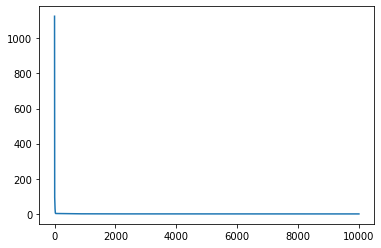

In [0]:
X = np.ones(100, dtype=np.float64)
X[0] = X[-2] = -1.2
xop = np.ones(100)

params = {
    'X': X,
    'f': f2,
    'g': f2_grad,
    'tol_x': 1e-10,
    'tol_f': 1e-10,
    'tol_g': 1e-10,
    'alpha': 1e-3,
    # 'alpha': 0.5,
    'q_k': 1.0,
    'eta': 0.5,
    'mxitr': 10000
}

ans = zhang_hager(**params)

print("iters: %d" % len(ans.x_log))
print("g norm", np.linalg.norm(ans.x_log[-1]))
print("f error", ans.f_log[-1] - f2(xop))
plt.plot(ans.g_norm_log)
# plt.plot(ans.f_log)

iters: 10001
g norm 1.9180671098530873
f error 7.87696275603011


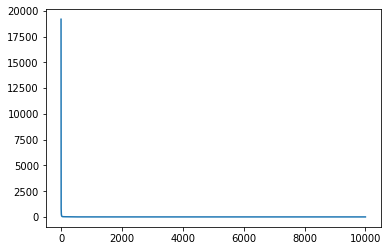

In [0]:
X = np.array([-3, -1, -3, -1], dtype=np.float64)

_lambda = 1
params = {
    'X': X,
    'f': f3,
    'g': f3_grad,
    'tol': 1e-10,
    'alpha': 1e-3,
    'mxitr': 10000
}

ans = zhang_hager(**params)

xop = np.ones(4)
print("iters: %d" % len(ans.x_log))
print("g norm", np.linalg.norm(ans.x_log[-1]))
print("f error", ans.f_log[-1] - f3(xop))
# plt.plot(ans.g_norm_log)
plt.plot(ans.f_log)

## Otro mas